In [1]:
import os, sys
import torch
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


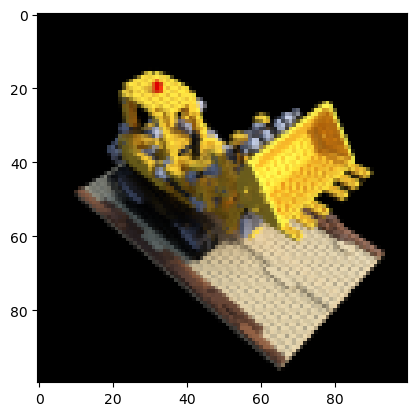

In [3]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

print(f"PyTorch is using {device}...")

def posenc(x):
    res = [x]
    for i in range(L_embed):
        for f in [torch.sin, torch.cos]:
            res.append(f(2.**i * x))
    return torch.concat(res, -1)


PyTorch is using cuda...


In [5]:

import torch.nn as nn

L_embed = 6
embed_fn = posenc

def get_rays(H, W, focal, c2w):

    # i, j = torch.meshgrid(torch.arange(H, dtype=torch.float), torch.arange(W, dtype=torch.float), indexing="xy")
    # dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1).to(device) # H x W x 3
    i, j = np.meshgrid(np.arange(H, dtype=np.float32), np.arange(W, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    dirs = torch.tensor(dirs, dtype=torch.float32)
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1) # correct one
    # rays_d = torch.matmul(dirs, c2w[:3, :3].transpose(1, 0)) # it should be the same as the above one? no, since precision error
    rays_o = c2w[:3, -1].expand_as(rays_d)
    # rays_o: H x W x 3 start of the rays
    # rays_d: H x W x 3 dir of the rays
    return rays_o, rays_d

class TinyNerf(nn.Module):
    def __init__(self, hidden_size=256) -> None:
        super(TinyNerf, self).__init__()

        input_size = 3 + 3 * 2 * L_embed

        self.block1 = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size), nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            # nn.Linear(hidden_size, hidden_size), nn.ReLU(),
        )
        
        # final layer
        self.output_layer = nn.Linear(hidden_size, 4)

        # self.init_weights()
    
    # def init_weights(self):
    #     nn.init.xavier_uniform_(self.model[0].weight)
    #     for i in range(self.depth):
    #         nn.init.xavier_uniform_(self.model[2*i+1].weight)
    #     nn.init.xavier_uniform_(self.model[-1].weight)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(torch.concat([out, x], -1))
        # out = self.block2(out)
        return self.output_layer(out)

In [6]:
def render_rays(model, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : torch.concat(
            [fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)],
            0,
        )

    # queries
    z_vals = torch.linspace(near, far, N_samples+1, device=device)[:-1] + (far - near) / N_samples * .5
    # z_vals = z_vals[None, None, :].expand(rays_o.shape[0], rays_o.shape[1], -1)
    if rand:
        if model.training:
            z_vals = z_vals + (torch.rand(list(rays_o.shape[:-1]) + [N_samples], device=device) - .5) * (far - near) / N_samples
        else:
            np.random.seed(0)
            z_vals = z_vals + torch.tensor(np.random.rand(*(list(rays_o.shape[:-1]) + [N_samples])) - .5, dtype=torch.float32) * (far - near) / N_samples
    # print("z_vals:", z_vals)

    # query points shape: H x W x N_sample x 3
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    intput = torch.reshape(pts, (-1, 3)) # N_rays x 3
    # print("points shape:", pts.shape)
    input = embed_fn(intput) # N_rays x (3 x 2 x L_embed)
    # print("input shape(no dirs):", input.shape)
    # input = torch.concat([input, rays_d[..., None, :].expand(-1, -1, N_samples, -1).reshape(-1, 3)], -1)
    # print("intput shape:", input.shape)

    output = batchify(model)(input)
    raw = torch.reshape(output, list(pts.shape[:-1]) + [4])
    # print("raw shape:", raw.shape)
    
    # Volume Rendering
    # compute sigma and rgb info
    sigma_a = torch.relu(raw[..., 3])
    rgb = torch.sigmoid(raw[..., :3])

    # dists = torch.concat(
    #     [z_vals[..., 1:] - z_vals[..., :-1], torch.tensor([1e10], device=device).expand_as(z_vals[..., -1:])],
    #     -1,
    # )
    dists = torch.concat(
        [torch.sum((pts[..., 1:, :] - pts[..., :-1, :])**2., -1)**.5, torch.tensor([1e10], device=device).expand(list(pts.shape[:-2]) + [1])],
        -1,
    )

    # print(dists)

    alpha = 1. - torch.exp(-sigma_a * dists)

    acc = torch.cumprod(1.-alpha + 1e-10, -1)
    acc = torch.concat([torch.ones(list(alpha.shape[:-1]) + [1], device=device), acc[..., :-1]], -1)
    weights = alpha * acc

    # print("weight shape:", weights.shape)
    # print("rgb shape:", rgb.shape)

    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)
    depth_map = torch.sum(weights * z_vals, dim=-1)
    acc_map = torch.sum(weights, dim=-1)

    # print("map shape: [rgb, depth, acc] =", rgb_map.shape, depth_map.shape, acc_map.shape)

    return rgb_map, depth_map, acc_map


# rays_o, rays_d = get_rays(3, 3, 1, torch.rand((4, 4)).to(device))
# print(rays_o.shape)
# model = TinyNerf().to(device)

# render_rays(model, rays_o, rays_d, 0., 1., 8, rand=True)

0 0.011337604522705078 secs per iter


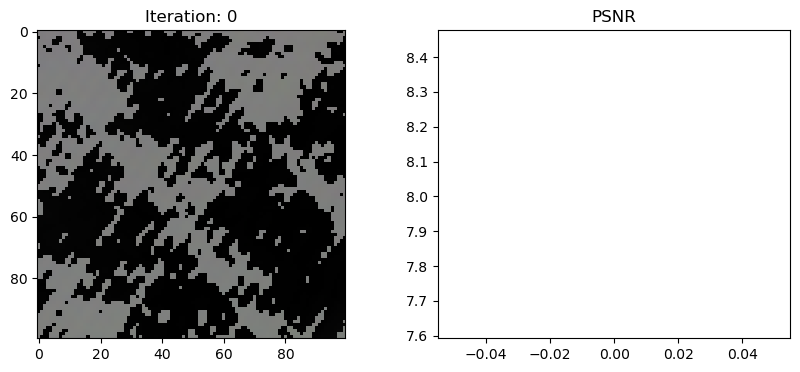

50 0.13196898460388184 secs per iter


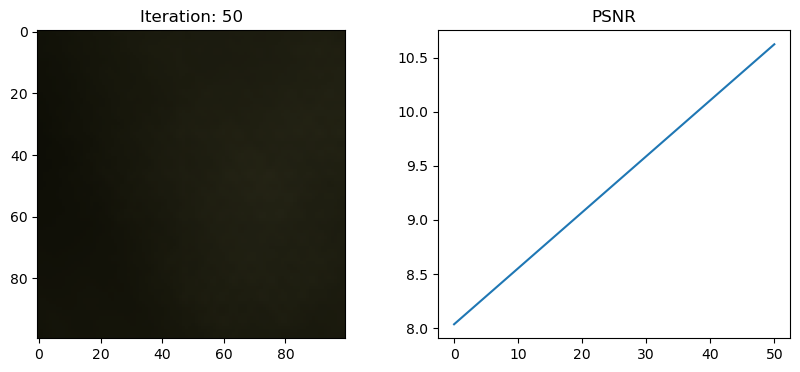

100 0.13155412673950195 secs per iter


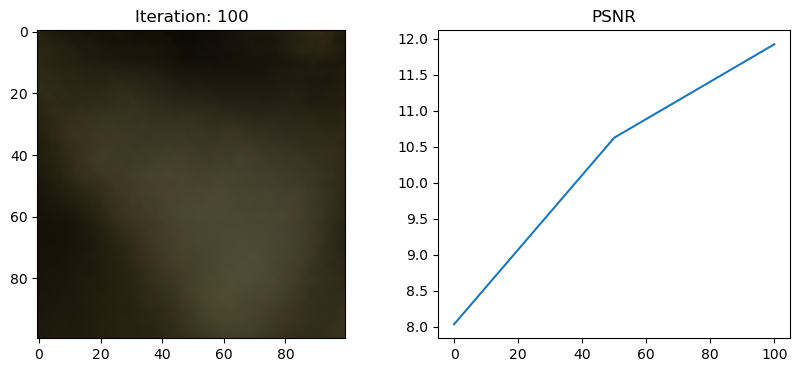

150 0.13261688709259034 secs per iter


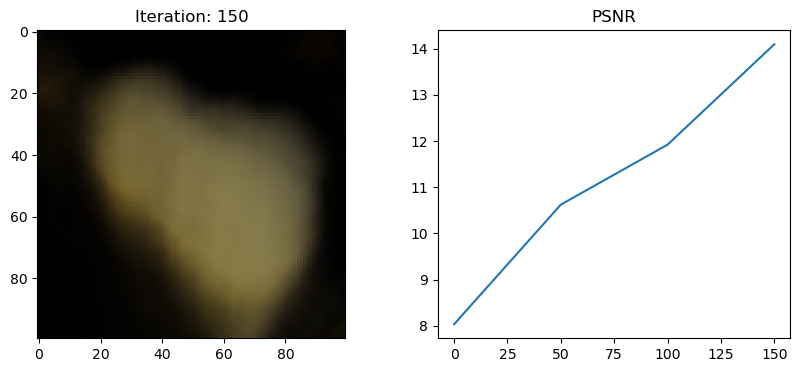

200 0.13209663867950439 secs per iter


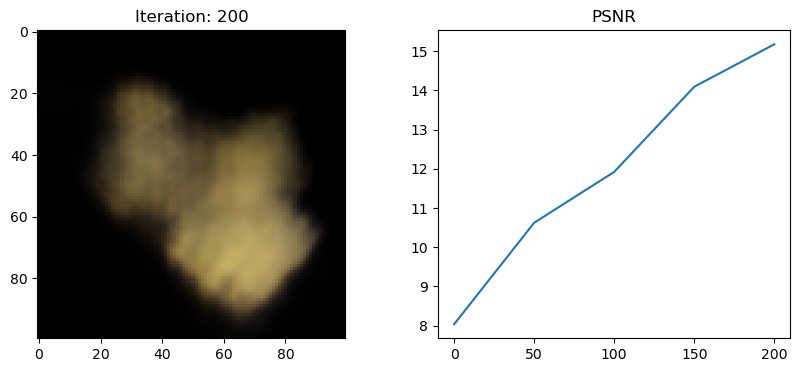

250 0.13136493682861328 secs per iter


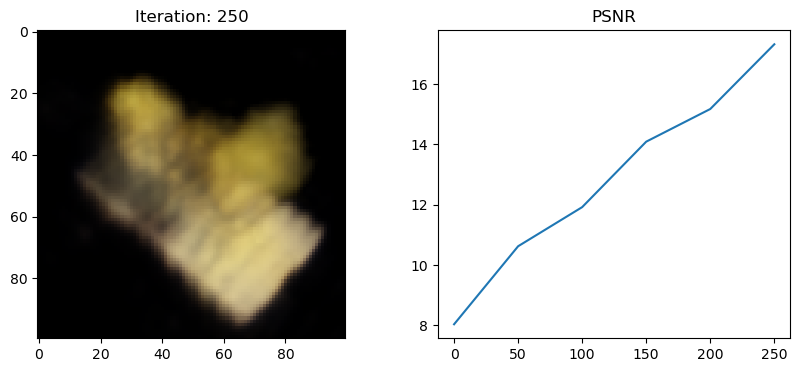

300 0.13171024799346923 secs per iter


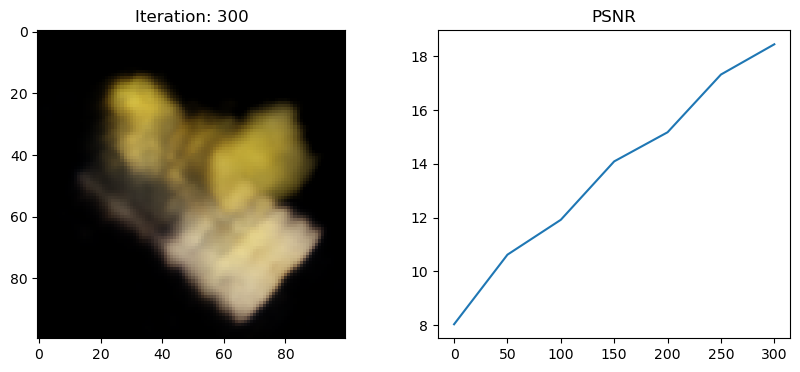

350 0.13156632900238038 secs per iter


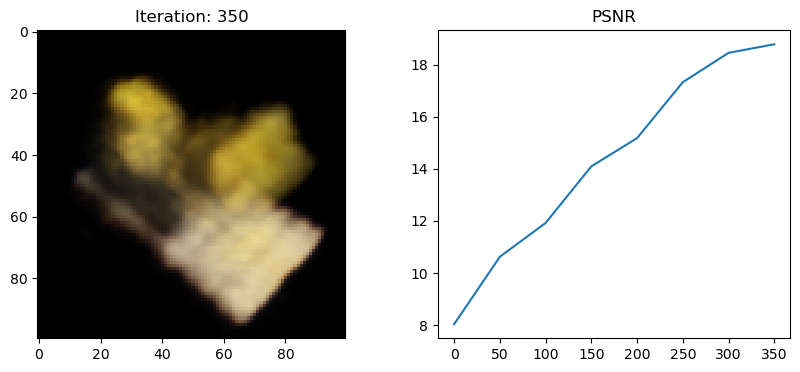

400 0.13456621170043945 secs per iter


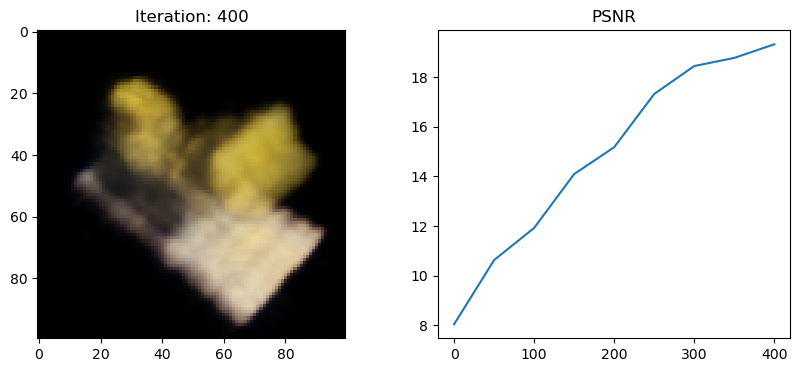

450 0.13193621158599853 secs per iter


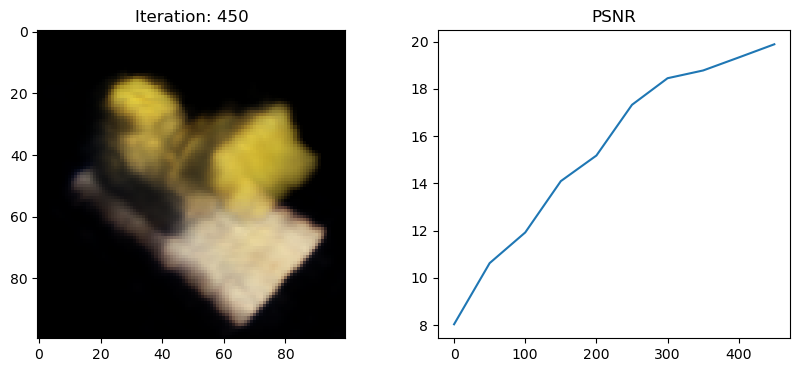

500 0.1336132049560547 secs per iter


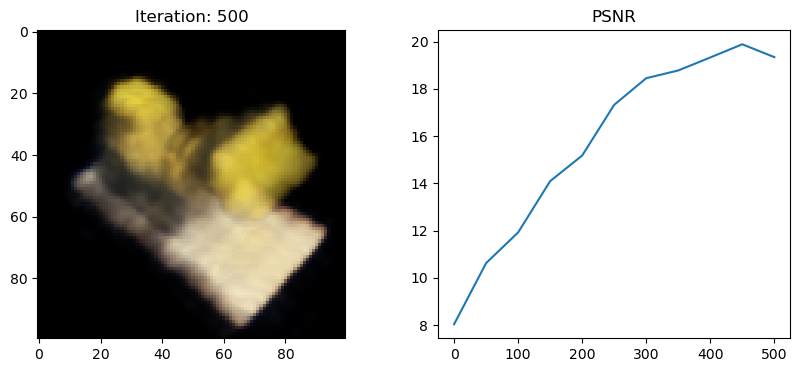

550 0.1489678716659546 secs per iter


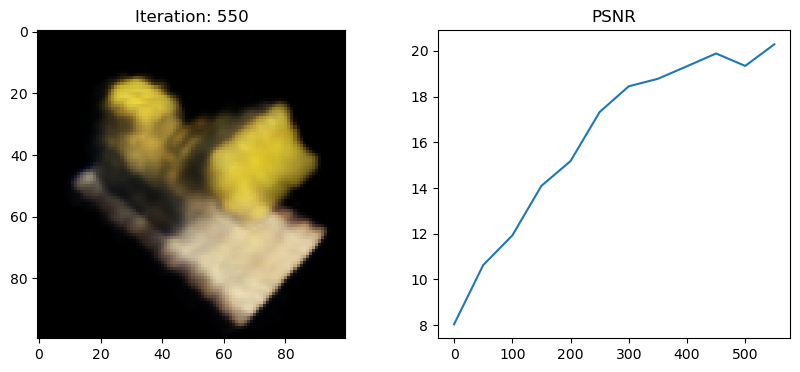

600 0.14022583961486818 secs per iter


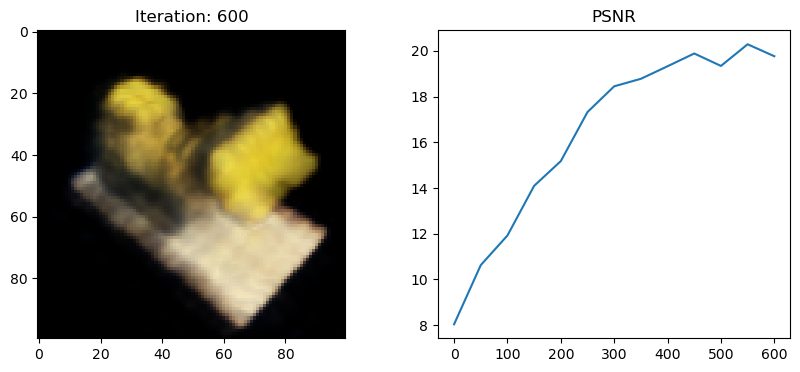

650 0.13474870204925538 secs per iter


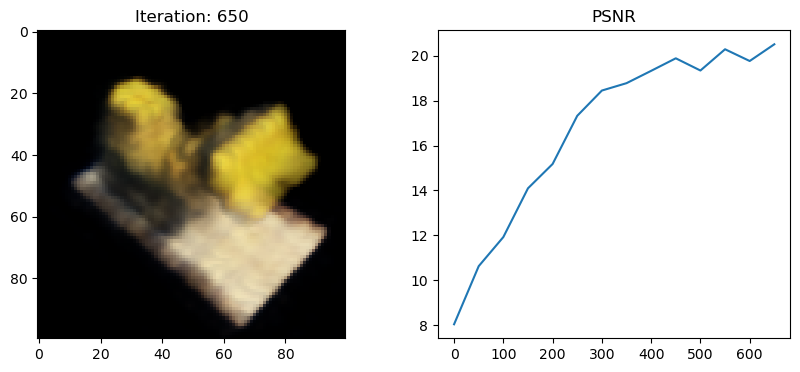

700 0.14100837230682373 secs per iter


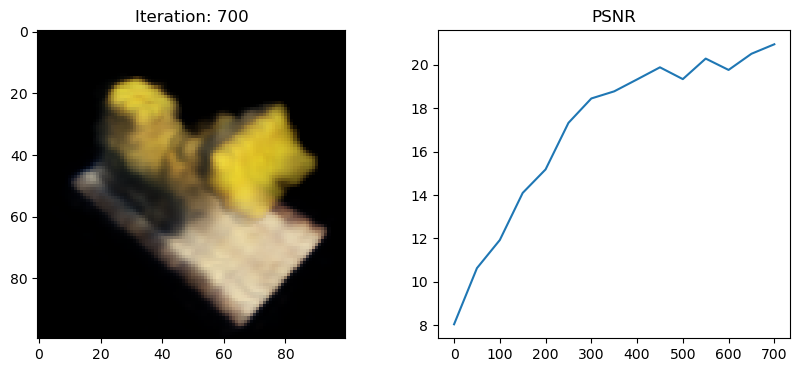

750 0.13242763996124268 secs per iter


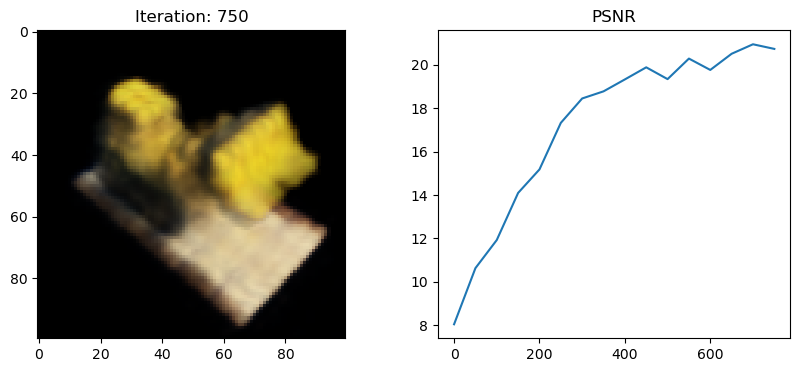

800 0.1342030096054077 secs per iter


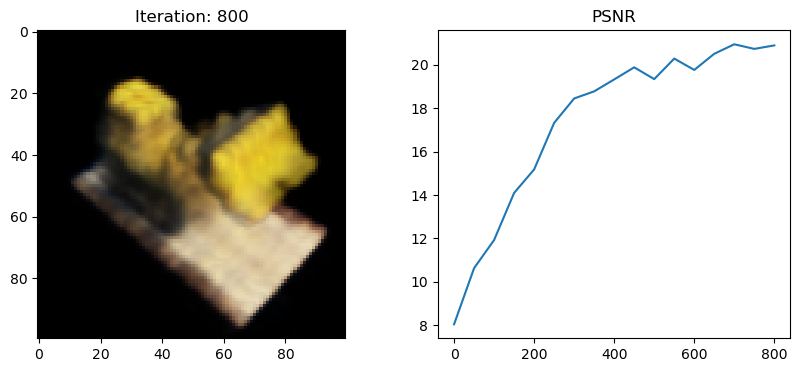

850 0.1325407075881958 secs per iter


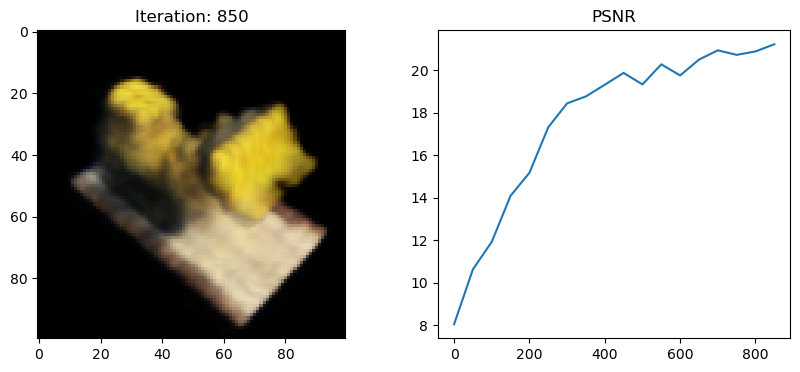

900 0.13493271350860594 secs per iter


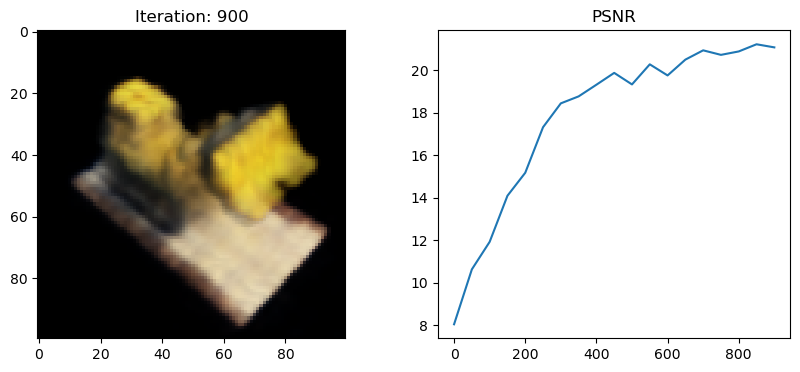

950 0.1326875066757202 secs per iter


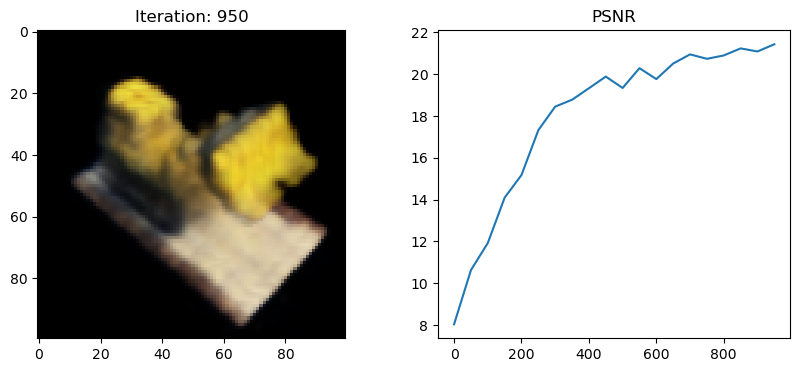

1000 0.13327069759368895 secs per iter


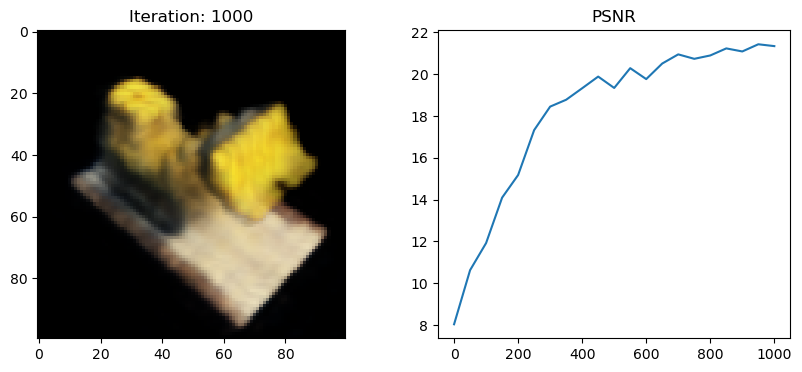

Done.


In [7]:
import torch.optim as optim
import torch.nn.functional as F

model = TinyNerf()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 50

testimg = torch.Tensor(testimg).to(device)
testpose = torch.Tensor(testpose).to(device)

import time
t = time.time()

for i in range(N_iters + 1):
    model.train()
    optimizer.zero_grad()
    
    img_i = np.random.randint(images.shape[0])
    target = torch.Tensor(images[img_i]).to(device)
    pose = torch.Tensor(poses[img_i]).to(device)

    rays_o, rays_d = get_rays(H, W, focal, pose)


    rgb, _, _ = render_rays(model, rays_o, rays_d, 2., 6., N_samples, True)

    loss = F.mse_loss(rgb, target)
    
    loss.backward()
    optimizer.step()

    if i % i_plot == 0:
        model.eval()
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = F.mse_loss(rgb, testimg)
        psnr = -10. * torch.log10(loss)

        psnrs.append(psnr.detach().cpu().numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb.detach().cpu().numpy())
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()
    
print("Done.")
    